In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import csv
import os
import random
import math

from torch import nn

In [2]:
STARTPOS_STAGE = 24
TARGET_COLUMN = 'target'
METAINFO_COLUMNS = ['stage', 'move_count', 'game_index', 'weight']
METAINFO_COLUMNS_COUNT = len(METAINFO_COLUMNS)
STAGE_INDEX = 0
MOVE_COUNT_INDEX = 1
WEIGHT_INDEX = 3
TARGET_INDEX = -1

In [3]:
class Row:
    def __init__(self, csv_line):
        self.X = np.array(csv_line[METAINFO_COLUMNS_COUNT:TARGET_INDEX], dtype=np.single)
        self.y = csv_line[TARGET_INDEX]
        self.w = csv_line[WEIGHT_INDEX]
        self.X = np.concatenate((self.X, 
                                self.X[6 + 7 + 64 * 5 : 6 + 7 + 64 * 6]))
        self.X[6 + 7 + 64 * 5 : 6 + 7 + 64 * 6] *= self.X[STAGE_INDEX] / 24
        self.X[6 + 7 + 64 * 6 : 6 + 7 + 64 * 7] *= 1 - self.X[STAGE_INDEX] / 24
        
    def get_not_features_count():
        return METAINFO_COLUMNS_COUNT + 1
    
    def get_X(self):
        return self.X
    
    def get_y(self):
        return self.y
    
    def get_w(self):
        return self.w

In [4]:
class StatCalcer:
    def __init__(self, row_size):
        self.max = np.zeros(row_size, dtype=np.single)
        self.min = np.full(row_size, 2 ** 16, dtype=np.single)
        self.cnt = 0

    def process_row(self, row):
        self.max = np.maximum(self.max, row.get_X())
        self.min = np.minimum(self.min, row.get_X())
        self.cnt += 1

    def get_max(self):
        return self.max
    
    def get_min(self):
        return self.min
    
    def get_cnt(self):
        return self.cnt


In [5]:
class SimpleDatasetHolder:
    def __init__(self, dataset_file, sample_test_rate):
        with open(dataset_file) as file:
            csv_reader = csv.reader(file)
            self.header = np.array(next(csv_reader))
            self.stat_calcer = StatCalcer(self.header.shape[0] - Row.get_not_features_count() + 64)
            self.train = []
            self.test = []
            while True:
                try:
                    row = Row(np.array(next(csv_reader), dtype=np.single))
                except:
                    break

                self.stat_calcer.process_row(row)
                if np.random.random() < sample_test_rate:
                    self.train.append(row)
                else:
                    self.test.append(row)
            
            self.train = np.array(self.train)
            self.test = np.array(self.test)

    def get_train_batch(self, batch_size):
        return self.train[np.random.choice(self.train.shape[0], batch_size)]
    
    def get_test_batch(self, batch_size):
        return self.test[np.random.choice(self.test.shape[0], batch_size)]
    
    def get_features_count(self):
        return self.train[0].get_X().shape[0]
    
    def get_stat_calcer(self):
        return self.stat_calcer

In [6]:
class DistributedDatasetHolder:
    def __init__(self, dataset_dir, sample_test_rate):
        self.dataset_dir = dataset_dir
        self.dataset_chunks = [entry for entry in os.listdir(dataset_dir) if os.path.isfile(os.path.join(self.dataset_dir, entry))]
        self.n = len(self.dataset_chunks)
        
        self.train_chunks_count = math.floor(len(self.dataset_chunks) * sample_test_rate + 0.49)
        print(self.train_chunks_count)
        # random.shuffle(self.dataset_chunks)
        self.dataset_chunks = sorted(self.dataset_chunks)
        print(self.dataset_chunks)

        self.open_files()

        self.shuffle()
        
        self.stat_calcer = StatCalcer(self.header.shape[0] - Row.get_not_features_count() + 64)
        self.calc_stat()
    
    def open_files(self):
        self.chunk_files = [open(os.path.join(self.dataset_dir, filename)) for filename in self.dataset_chunks]
        self.csv_readers = [csv.reader(file) for file in self.chunk_files]
        for i in range(self.n):
            self.header = np.array(next(self.csv_readers[i]))

    def close_files(self):
        for file in self.chunk_files:
            file.close()

    def reopen_files(self):
        self.close_files()
        self.open_files()

    def calc_stat(self):
        print("calc")
        self.reopen_files()
        for i in range(self.n):
            while True:
                try:
                    row = Row(np.array(next(self.csv_readers[i]), dtype=np.single))
                except:
                    break
                self.stat_calcer.process_row(row)
        self.reopen_files()
        print(self.stat_calcer.get_cnt())

    def shuffle_file(self, filename):
        with open(os.path.join(self.dataset_dir, filename)) as file:
            lines = np.array(file.readlines())
            np.random.shuffle(lines[1:])
        with open(os.path.join(self.dataset_dir, filename), 'w') as file:
            file.writelines(lines)
        # df = pd.read_csv(os.path.join(self.dataset_dir, filename))
        # df = df.sample(frac=1)
        # df.to_csv(os.path.join(self.dataset_dir, filename), index=False)
        
    def shuffle(self):
        print("shuffle")
        for filename in self.dataset_chunks:
            self.shuffle_file(filename)
        self.reopen_files()

    def get_batch(self, left_pos, right_pos, batch_size):
        batch = []
        size = 0
        while size < batch_size:
            pos = random.randint(left_pos, right_pos - 1)
            try:
                row = Row(np.array(next(self.csv_readers[pos]), dtype=np.single))
            except:
                self.shuffle()
                return self.get_batch(left_pos, right_pos, batch_size)
            size += 1
            batch.append(row)
        return np.array(batch)

    def get_train_batch(self, batch_size):
        return self.get_batch(0, self.train_chunks_count, batch_size)
    
    def get_test_batch(self, batch_size):
        return self.get_batch(self.train_chunks_count, self.n, batch_size)
    
    def get_features_count(self):
        return self.header.shape[0] - Row.get_not_features_count()
    
    def get_stat_calcer(self):
        return self.stat_calcer
    
    def __del__(self):
        self.close_files()

In [7]:
dataset_holder = DistributedDatasetHolder('/home/wind-eagle/quirky_data/dataset', 0.9)

9
['1.csv', '10.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv']
shuffle
calc
3580550


In [8]:
stat_calcer = dataset_holder.get_stat_calcer()
X_max = stat_calcer.get_max()
X_min = stat_calcer.get_min()
X_norm = X_max - X_min
X_norm = np.maximum(np.min(X_norm[X_norm > 1e-9]), X_norm)

In [11]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(dataset_holder.get_features_count() + 64, 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())
opt = torch.optim.Adam(model.parameters(), lr=0.01)

def get_loss(model, X, y, w, C=0.0):
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 2)
    return loss

def get_weights():
    ww = (model.linear.weight[0]).detach().numpy() / X_norm
    for i in range(5):
        l = 6 + 7 + 64 * i
        r = 6 + 7 + 64 * (i + 1)
        if i == 0:
            l += 8
            r -= 8
        m = np.median(ww[l:r])
        ww[l:r] -= m
        ww[i] += m

    ww = (ww / ww[0] * 100).astype(np.int32)
    return ww

In [12]:
def main_learning(iter_count):
    C = 5e-5
    history = []

    for i in range(iter_count):
        batch = dataset_holder.get_train_batch(16384)
        X_batch = torch.tensor([r.get_X() / X_norm for r in batch], dtype=torch.float32)
        y_batch = torch.tensor([r.get_y() for r in batch], dtype=torch.float32)
        w_batch = torch.tensor([r.get_w() for r in batch], dtype=torch.float32)

        loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

        loss.backward()
        
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())

        # выводим результаты
        if i % 100 == 0:
            print(get_weights())
        if i % 100 == 0:
            batch = dataset_holder.get_test_batch(16384)
            X_test_batch = torch.tensor([r.get_X() / X_norm for r in batch], dtype=torch.float32)
            y_test_batch = torch.tensor([r.get_y() for r in batch], dtype=torch.float32)
            w_test_batch = torch.tensor([r.get_w() for r in batch], dtype=torch.float32)
            test_loss = get_loss(model,
                torch.tensor(X_test_batch, dtype=torch.float32),
                torch.tensor(y_test_batch, dtype=torch.float32),
                torch.tensor(w_test_batch, dtype=torch.float32),
                C=0.0).detach().numpy().sum()
            train_loss = np.mean(history[-40:])
            print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")
        elif i % 10 == 0:
            train_loss = np.mean(history[-40:])
            print(f"step #{i}, train_loss = {train_loss:.4f}")
        

main_learning(10500)

[  100   165   603   -11   439  -911   127   -53    24  -871   210   -87
   195  -482 -2973  -151 -2996  -697  2888 -1355   442   441  -233   464
    69  -233   889   404   802  -405   427  -142  -292   383  -330  -363
  -239  -548  -383   130   -34   432   804  -468    26   -54   734   145
   300  -353  -567   822  -532   204  -559   226  -578  -305   710   123
  -487  -125   559   -26   448  -174   387  -394   266 -1879   519  -976
  2473  2888  -399 -3003 -2867  -640   191  -264   201   104   186   415
   306   580   842  -618  -169  -480   327   139   416   600  -316   -40
  -295  -325   -13   -82  -195   379   -25  -282   730   743   221  -492
  -373   754  -178    -2   365  -398  -239   950  -422     2   -56  -417
   151  -449   809   -82   750   331   365  -369  -430  -166  -371  -344
  -506   643   630   783    49  -374   872   148   308   170   118 -1017
  -815  -401  -212   351   126  -444   140  -865    59    31  -539   134
  -468   251    58   698   329   664  -687  -581  -

<ipython-input-12-289769a312a5>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_test_batch, dtype=torch.float32),
<ipython-input-12-289769a312a5>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_test_batch, dtype=torch.float32),
<ipython-input-12-289769a312a5>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(w_test_batch, dtype=torch.float32),


step #0, train_loss = 0.1820, test_loss = 0.1778
step #10, train_loss = 0.1749
step #20, train_loss = 0.1692
step #30, train_loss = 0.1642
step #40, train_loss = 0.1600
step #50, train_loss = 0.1526
step #60, train_loss = 0.1474
step #70, train_loss = 0.1437
step #80, train_loss = 0.1408
step #90, train_loss = 0.1386
[ 100   99  119  110  153    0    1  -19   22  -93   35   30   36    0
    0    0    0    0    0    0    0   -7    8  -12  -27  -32    3    6
   -6    6    3  -25  -16  -15  -15    0  -12  -11    8  -16  -19  -26
  -16   -8  -34    0   -6    0  -12  -17  -14  -18  -31   24   23   25
   19   14   16   19    6   27   34   31   35   26   22   18   20    0
    0    0    0    0    0    0    0 -121  -70 -105  -81  -49 -123  -68
   -2  -26  -96  -22  -39  -10  -37  -14  -14  -69  -48  -19   19    9
   -4    5  -80  -39   -5   22    0   33   33    0  -37  -15   -3   28
   38   32   37   12    9   12   32   28   55   28   31   12    4  -46
  -33   23   26    2   32   12  -25   18  

KeyboardInterrupt: 

In [15]:
weights = get_weights()
weights

array([ 100,  214,  246,  362,  693,    0,  -12,  -27,   24,  -38,    6,
         -3,   34,    0,    0,    0,    0,    0,    0,    0,    0,  -16,
         -5,  -10,  -18,  -14,    2,   -2,  -21,    0,    4,  -13,  -12,
          0,    0,    0,  -18,   -6,    0,   -5,  -12,  -12,   -4,  -10,
        -26,   10,   -2,   14,    0,    0,    0,   -5,   -7,   56,   63,
         56,   58,   46,   34,   61,   43,  140,  132,  141,  129,  119,
        132,  101,  108,    0,    0,    0,    0,    0,    0,    0,    0,
        -62,  -32,  -63,  -14,   -9,  -49,  -40,  -20,  -12,  -71,   17,
         -4,    6,    7,    9,   -8,  -32,  -14,    2,   35,   25,   13,
         27,  -27,   -8,    1,   32,   14,   22,   27,    9,  -16,   -2,
         16,   22,   21,   36,   40,   22,   23,    0,   15,  -10,   59,
         16,   25,   18,    0,  -70,  -41,   14,   21,    4,   43,  -15,
        -13, -110,  -83,  -43,  -24,   -2,  -43,   -8,  -87,  -58,  -16,
        -29,    8,   -9,  -36,  -32,  -40,  -43,   

In [16]:
weights[:6]

array([100, 214, 246, 362, 693,   0], dtype=int32)

In [17]:
weights[6 : 7 + 6]

array([-12, -27,  24, -38,   6,  -3,  34], dtype=int32)

In [19]:
def display_mat(mat, add):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

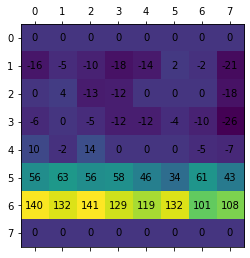

In [20]:
display_mat(weights[6 + 7 + 64 * 0 : 6 + 7 + 64 * 1].reshape(8, 8), weights[0])

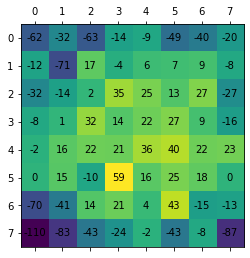

In [21]:
display_mat(weights[6 + 7 + 64 * 1 : 6 + 7 + 64 * 2].reshape(8, 8), weights[1])

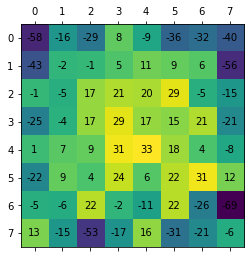

In [22]:
display_mat(weights[6 + 7 + 64 * 2 : 6 + 7 + 64 * 3].reshape(8, 8), weights[2])

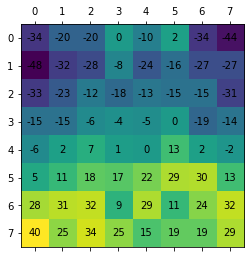

In [23]:
display_mat(weights[6 + 7 + 64 * 3 : 6 + 7 + 64 * 4].reshape(8, 8), weights[3])

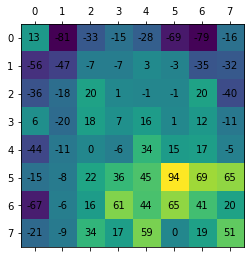

In [24]:
display_mat(weights[6 + 7 + 64 * 4 : 6 + 7 + 64 * 5].reshape(8, 8), weights[4])

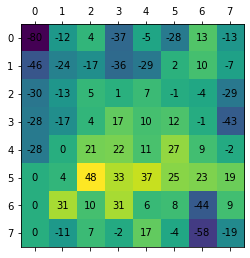

In [ ]:
display_mat(weights[6 + 7 + 64 * 5 : 6 + 7 + 64 * 6].reshape(8, 8), weights[5])

In [ ]:
display_mat(weights[6 + 7 + 64 * 6 : 6 + 7 + 64 * 7].reshape(8, 8), weights[5])